In [1]:
import math
import itertools

import pandas as pd
from sqlalchemy.sql import select

from predict_aqi.load_data import (
    AirLocation, get_db_session, load_air_location_data, load_measurement_data,
    load_nearby_location_measurement_data
)

# Select some airlocation with bad aqi
session = get_db_session()
s = select([AirLocation]).where(AirLocation.aqi > 100)
some_airlocation_ids = [x['id'] for x in session.execute(s)]

/opt/conda/lib/python3.5/site-packages/sqlalchemy/dialects/postgresql/base.py:2503: SAWarning: Did not recognize type 'geometry' of column 'coordinates'
  (attype, name))


In [2]:
# Select classifier to use
from sklearn.neural_network import MLPRegressor
from predict_aqi.model import generate_AQI_inputs_and_outputs
from predict_aqi import config


indices_ahead_to_predict = range(2, config.NUMBER_AHEAD_TO_PREDICT + 2, 2)
indices_behind_to_use = range(1, 48)


def load_data_for_airlocation(airlocation_id):
    some_airlocation = load_air_location_data(airlocation_id)
    
    print("Loading {}, {}".format(some_airlocation.short_name, some_airlocation.en_country_name))
    
    measurements = load_measurement_data(airlocation_id)
    df, input_columns, output_columns = generate_AQI_inputs_and_outputs(
        measurements, indices_behind_to_use, indices_ahead_to_predict
    )
    return df, input_columns, output_columns

In [17]:
import matplotlib.pyplot as plt


def generate_data_graph(dfs, axis_range=None):
    plt.figure(figsize=(15, 10))
    if not axis_range:
        axis_range = [0.0, 120000000.0, 0.0, 250.0] 
    plt.axis(axis_range)
    for index, df in enumerate(dfs):
        plt.scatter(
            df['id'],
            df['aqi'], 
            label="cleaned aqi over time",
            color=str(index / len(dfs)),
            s=2, lw=1
        )
    #plt.legend(loc=6, bbox_to_anchor=(0, 0.3))
    #plt.suptitle("Absolute AQI error on predictions for the next 24 hours", fontsize=20)

Loading Mudanjiang, China


37567
26181


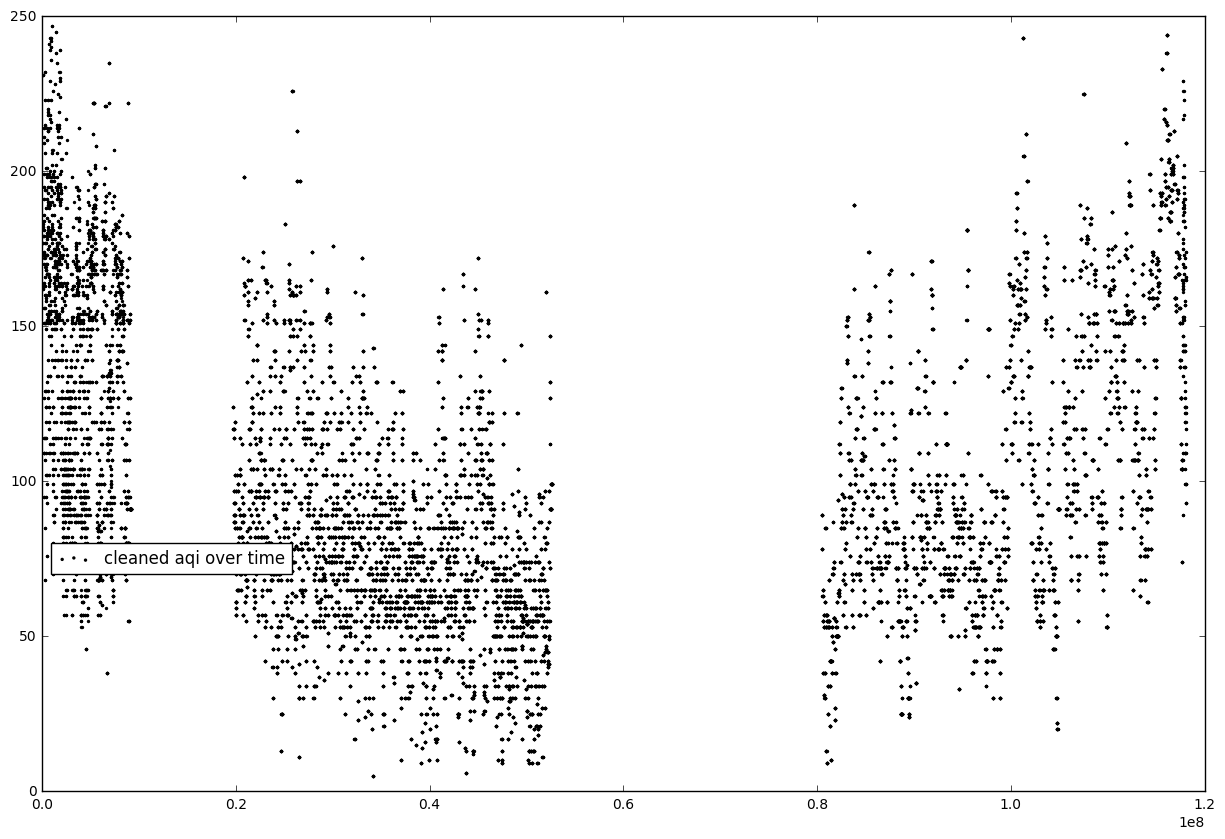

In [60]:
df, input_columns, output_columns = load_data_for_airlocation(some_airlocation_ids[0])

df['all_input_equal'] = df[input_columns].apply(lambda x: len(set(x)) < 3, axis=1)

print(df.count()[0])
print(df[df['all_input_equal'] == False].count()[0])

generate_data_graph([df[df['all_input_equal'] == False]], [0.0, 120000000.0, 0.0, 250.0])

In [ ]:
36380